# ECSE415 - Intro. to Computer Vision
# Assignment 4 Solutions

## Problem 1 - Bag-of-Words Model

In [202]:
import numpy as np
import os
import cv2

# Helper Functions #
def read_caltect(data_path):
    """
    Read images from Caltect101 dataset.
    
    @param data_path: string of dataset path
    
    @return X: array of images
    @return Y: array of labels
    @return categories: list of all categories
    """
    X = []
    y = []
    categories = os.listdir(data_path)
    for c in categories:
        c_path = data_path + '/' + c
        img_list = os.listdir(c_path)
        for i, img_name in enumerate(img_list):
            img_path = c_path + '/' + img_name
            img = cv2.imread(img_path)
            img = cv2.resize(img, (288, 192))
            X.append(img)
            y.append(categories.index(c))
    return np.array(X), np.array(y), categories

def compute_SIFT(X, num_features):
    """
    Compute SIFT features for input data X.
    
    @param X: list of input images
    @param num_features: number of SIFT features to retain
    
    @return X_feats: array of features for each image
    """
    # list of features for dataset (128 dimension for SIFT feature)
    X_feats = np.zeros((X.shape[0], num_features, 128))
    # SIFT object
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=num_features)
    for i, img in enumerate(X):
        # compute SIFT descriptors
        _, des = sift.detectAndCompute(img, None)
        X_feats[i, :des.shape[0]] = des[:num_features]
    return np.squeeze(X_feats)

def compute_HOG(X):
    """
    Compute HoG features for input data X.
    
    @param X: list of input images
    
    @return X_feats: array of features for each image
    """
    # HoG parameters
    winSize = (288, 192)
    blockSize = (32, 32)
    blockStride = (16,16)
    cellSize = (16, 16)
    nbins = 9
    X_feats = []
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
    for x in X:
        h = hog.compute(x)
        # last dimension shape is 36 for HoG with the above params
        h = np.reshape(h, (-1, 36))
        X_feats.append(h)
    X_feats = np.array(X_feats)
    return X_feats

def split_dataset(X, y):
    """
    Split dataset into training, validation and testing sets,
    use 50% for training, 25% for validation and 25% for testing.
    
    @param X: input feature array
    @param y: input category labels
    
    @return X_train: training features
    @return y_train: training labels
    @return X_valid: validation features
    @return y_valid: validation labels
    @return X_test: testing features
    @return y_test: testing labels
    """
    num_images = X.shape[0]
    idx = np.random.permutation(num_images)
    idx_train = int(0.5 * num_images)
    idx_valid = int(0.75 * num_images)
    X_train = X[idx[:idx_train]]
    y_train = y[idx[:idx_train]]
    X_valid = X[idx[idx_train:idx_valid]]
    y_valid = y[idx[idx_train:idx_valid]]
    X_test = X[idx[idx_valid:]]
    y_test = y[idx[idx_valid:]]
    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [211]:
import cv2
from sklearn.cluster import KMeans
from sklearn import svm
import matplotlib.pyplot as plt

class BagOfWords:
    """ Bag-of-Words Model. """
    def __init__(self, num_words):
        """
        Initialize parameters.
        
        @param num_words: number of words in codebook
        """
        self.K = num_words
        self.kmeans = None  # kmeans parameters
        self.clf = None  # svm classifier parameters
        
    def __compute_codebook(self, X_train):
        """
        Computes codebook for Bag-of-Words.
        
        @param X_train: list of training data
        
        @modifies kmeans: stores kmeans information
        """
        all_feats = np.reshape(X_train, (-1, X_train.shape[2]))
        # compute kmeans clustering
        kmeans = KMeans(n_clusters=self.K, n_init=1).fit(all_feats)
        # store kmeans in model
        self.kmeans = kmeans
    
    def __quantize_features(self, X):
        """
        Compute Bag-of-Words features (i.e. transform to closest visual word
        in dictionary).
        
        @param X: array of data
        
        @return X_trans: array of quantized data
        """
        X_trans = np.zeros((X.shape[0], self.K))
        for i, x_data in enumerate(X):
            # compute features based on codebook
            feats = self.kmeans.predict(x_data)
            feats_hist, _ = np.histogram(feats, bins=self.K)
            # normalize
            feats_hist = feats_hist / np.sum(feats_hist)
            X_trans[i] = feats_hist
        return X_trans
    
    def train(self, X_train, y_train):
        """
        Train Bag-of-Words model.
        
        @param X_train: array of training data in format
                        [num_examples, num_sift_des, 128]
        @param y_train: array of training labels
        
        @modifies self.clf: stores svm classifier
        """
        self.__compute_codebook(X_train)
        X_train = self.__quantize_features(X_train)
        # create SVM classifier
        clf = svm.LinearSVC()
        clf.fit(X_train, y_train)
        # store svm model
        self.clf = clf
        
    def score(self, X_test, y_test):
        """
        Compute mean accuracy score.
        """
        X_test = self.__quantize_features(X_test)
        acc = self.clf.score(X_test, y_test)
        return acc
    
    def display_images(self, X, X_feats, y, categories, feat_type):
        """
        Display 5 images and their respective histograms from each
        category.
        
        @param X: array of images
        @param X_feats: array of image features
        @param Y: array of labels
        @param categorires: list of image categories
        @param feat_type: string containing type of features used
        """
        sp = [(0,1), (2,3), (4,5), (6,7), (8,9)]
        for i in range(len(categories)):
            indices = np.where(y==i)[0][:5]
            x_feats = self.__quantize_features(X_feats[indices])
            plt.figure(figsize=(10,10))
            for j, idx in enumerate(indices):
                x_disp = X[idx]
                x_hist = x_feats[j]
                plt.subplot('52' + str(sp[j][0]))
                plt.bar(np.arange(self.K), x_hist)
                plt.subplot('52' + str(sp[j][1]))
                plt.imshow(cv2.cvtColor(x_disp, cv2.COLOR_BGR2RGB))
                plt.title(categories[i]), plt.xticks([]), plt.yticks([])
            plt.suptitle('K = ' + str(self.K) + ', ' + feat_type)
        plt.show()   

X_sift: (2472, 100, 128)
X_hog: (2472, 187, 36)


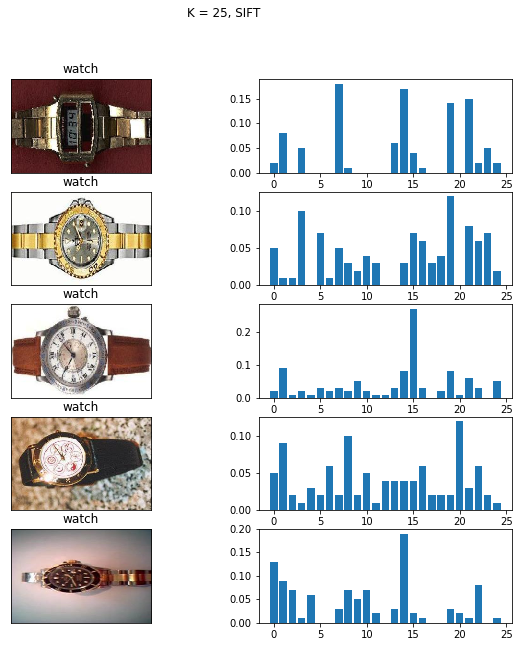

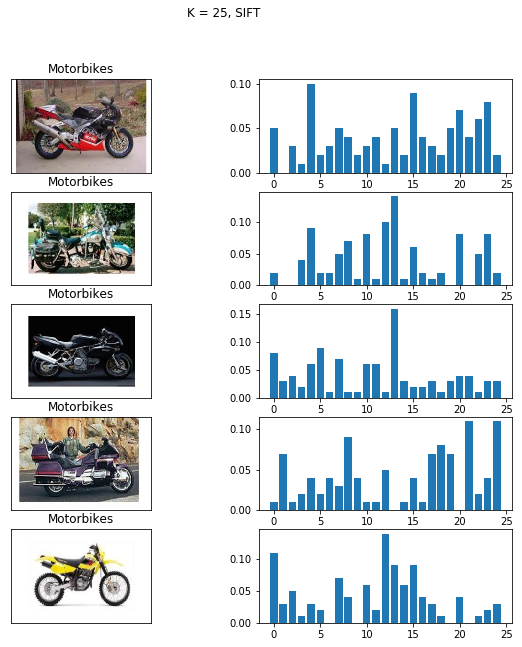

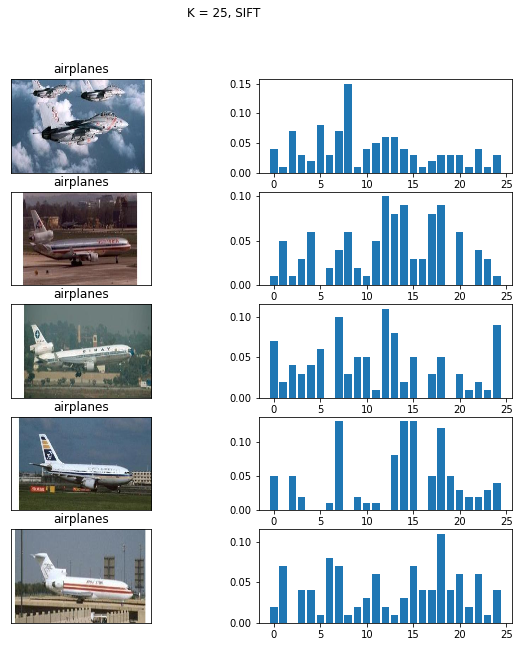

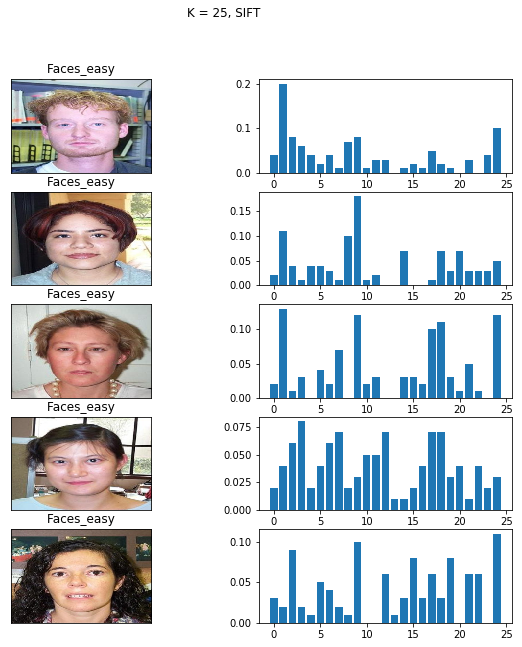

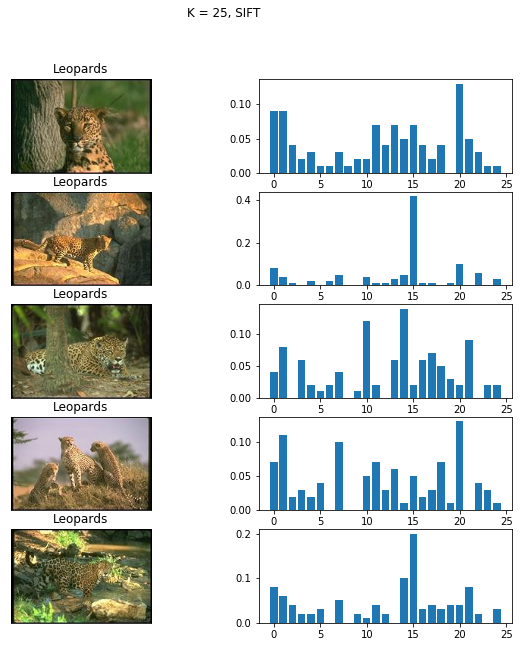

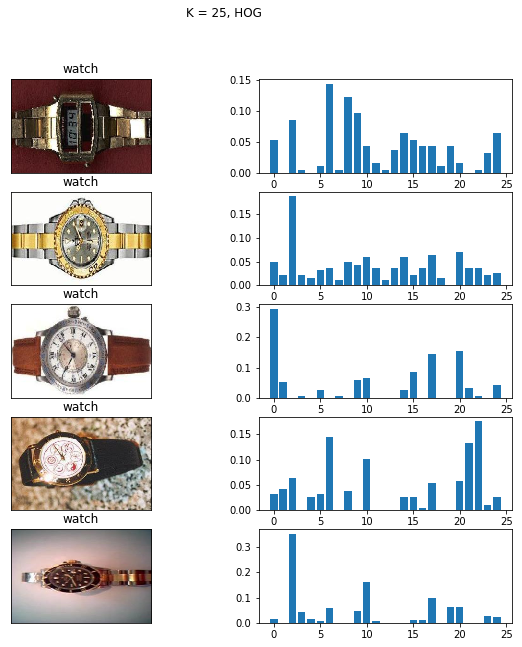

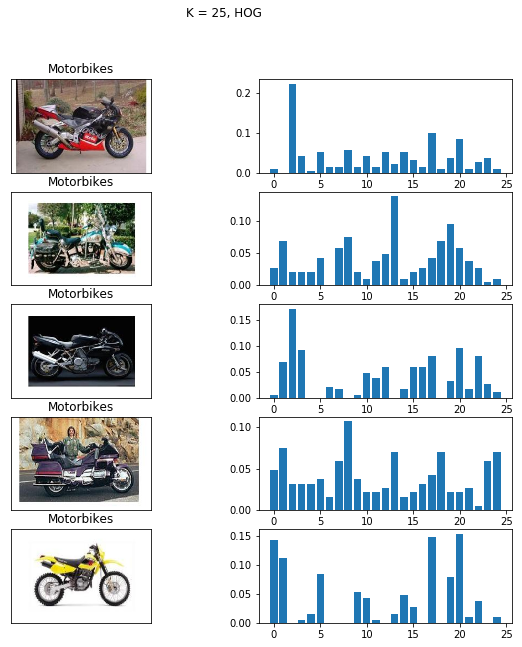

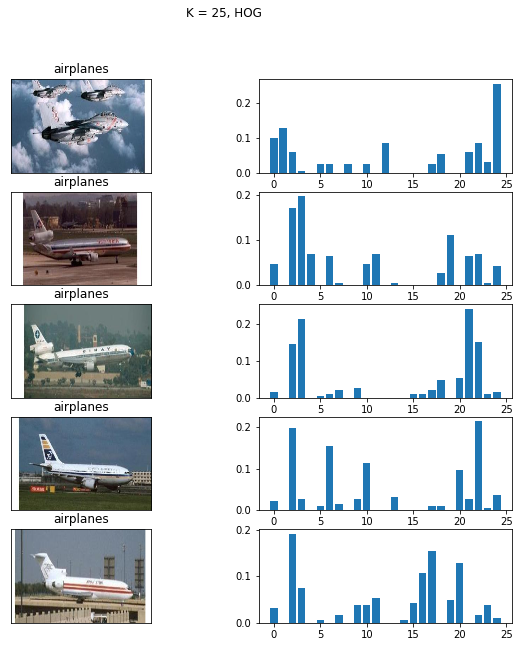

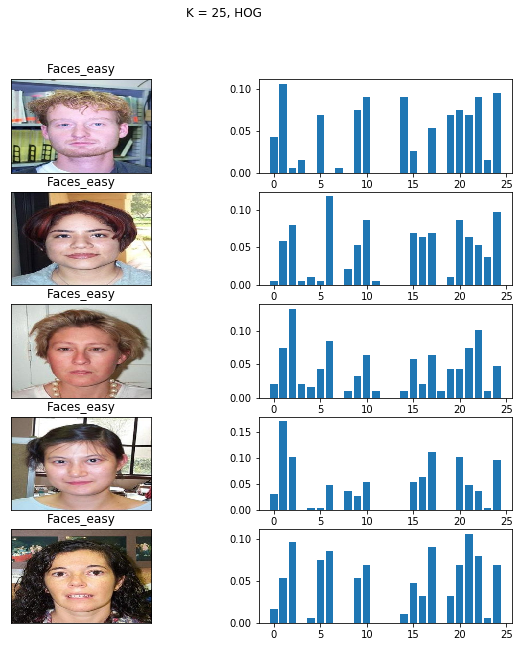

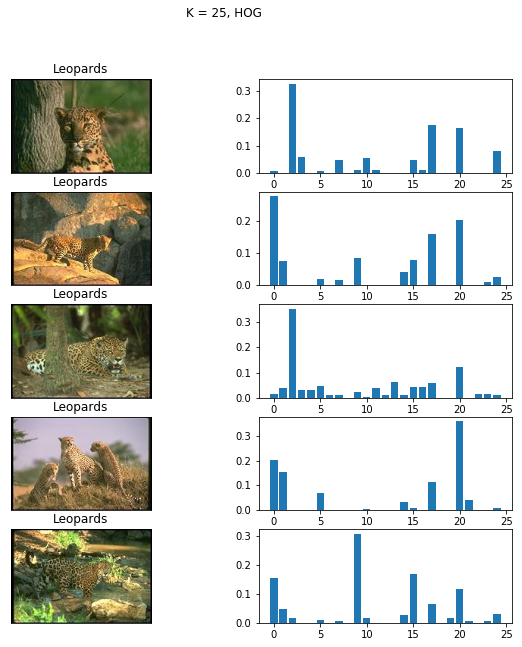

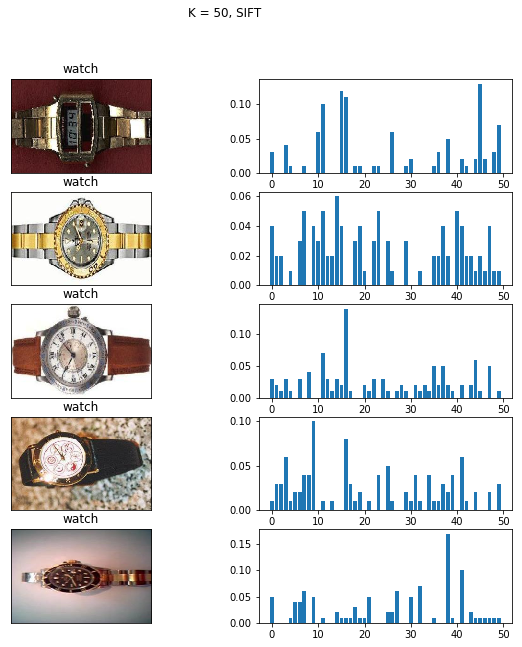

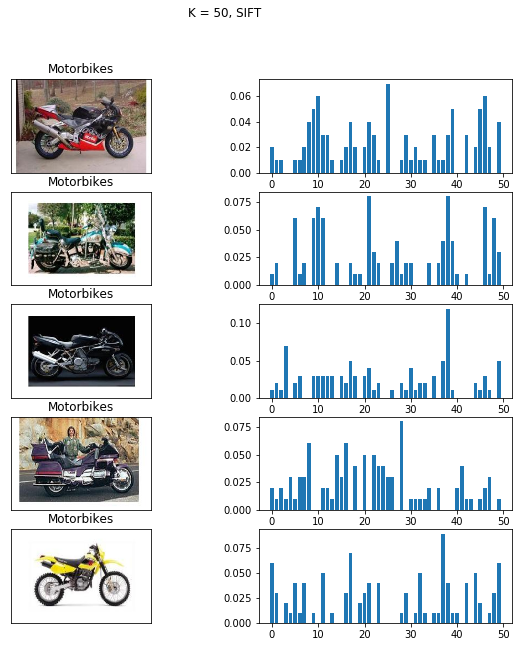

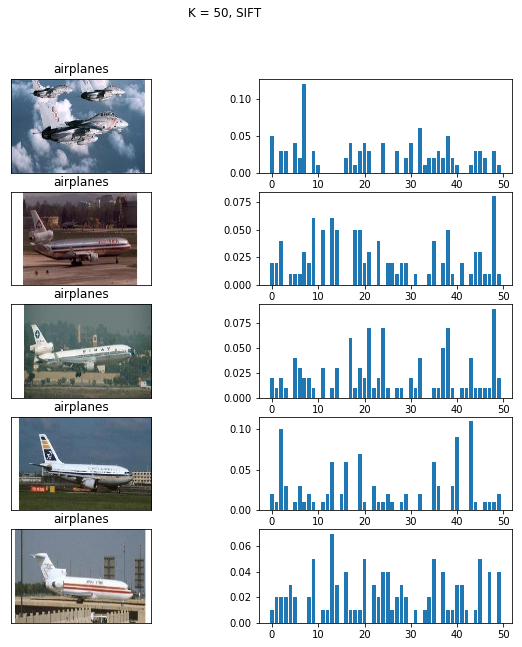

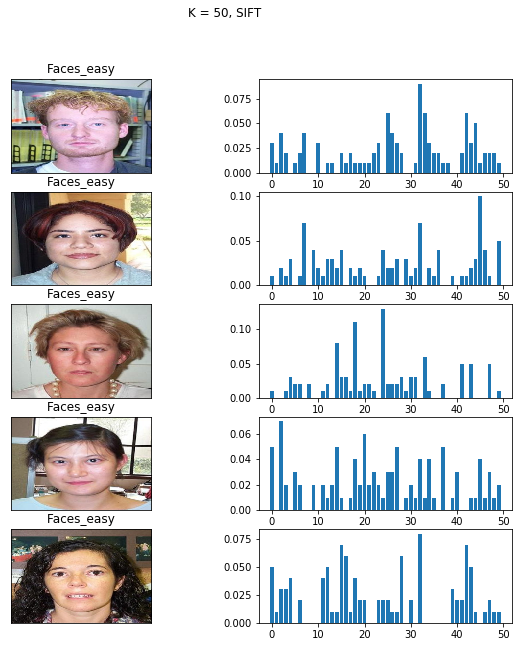

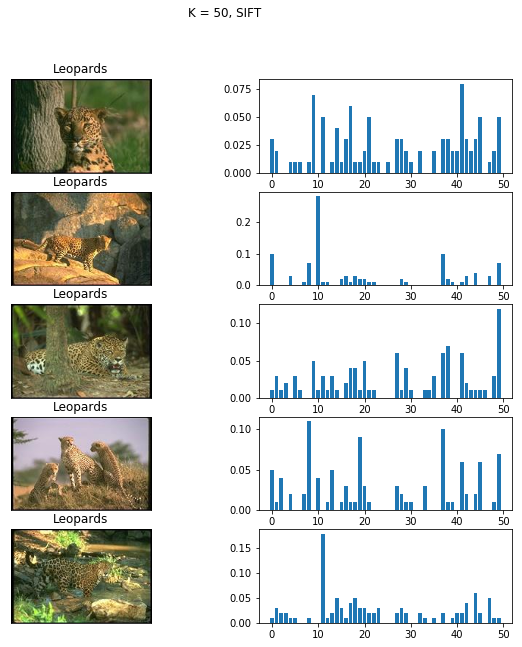

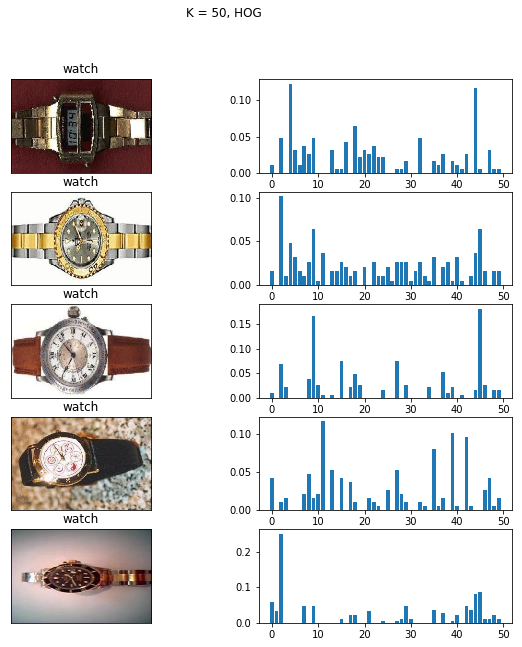

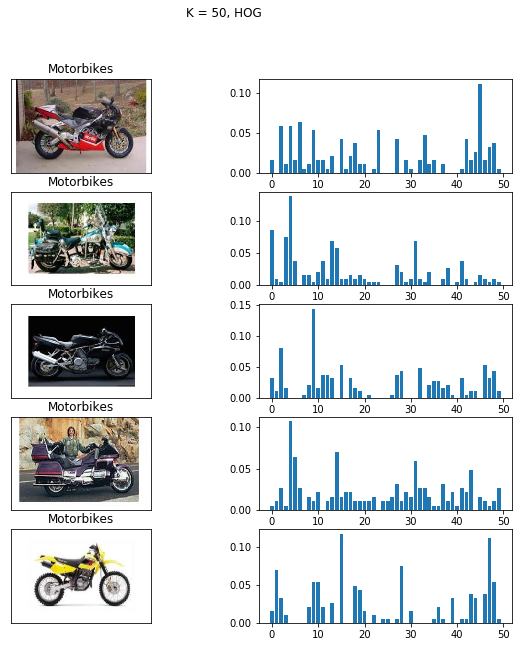

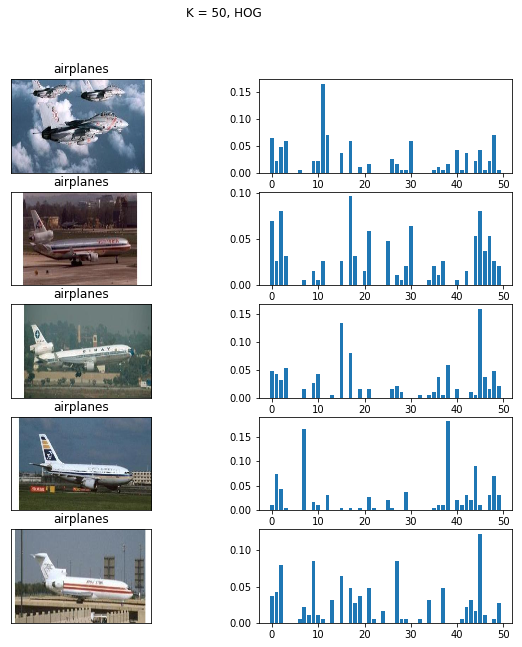

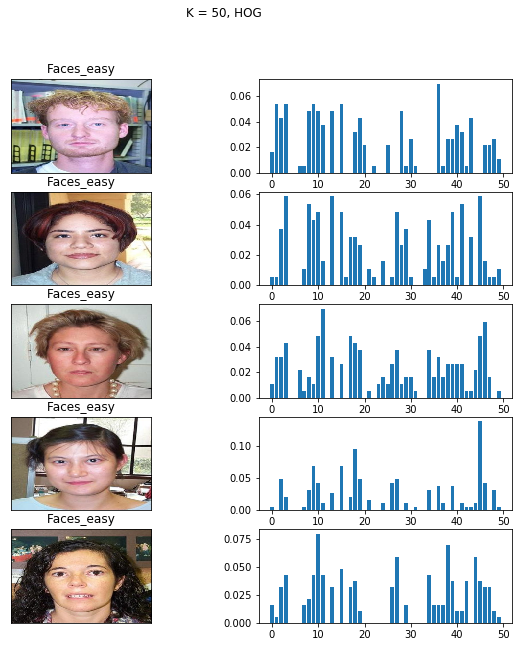

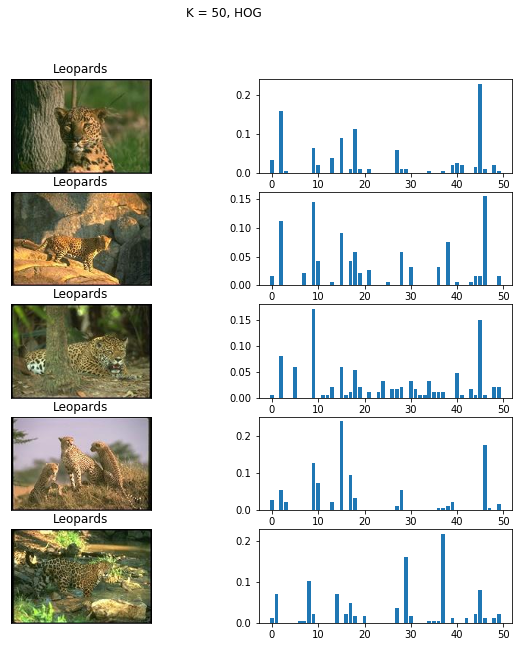

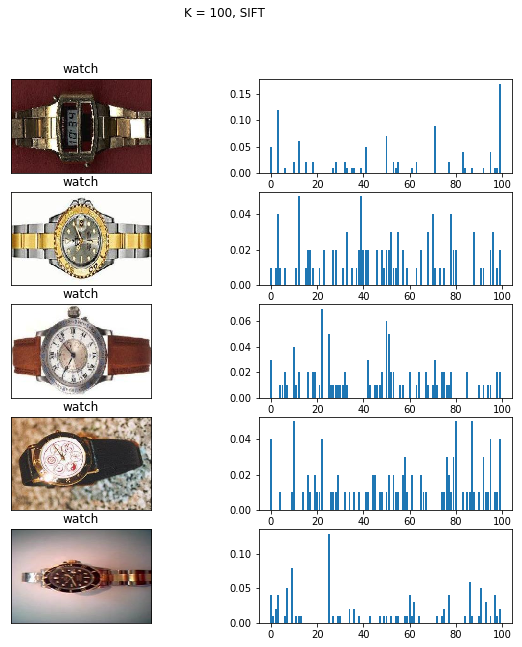

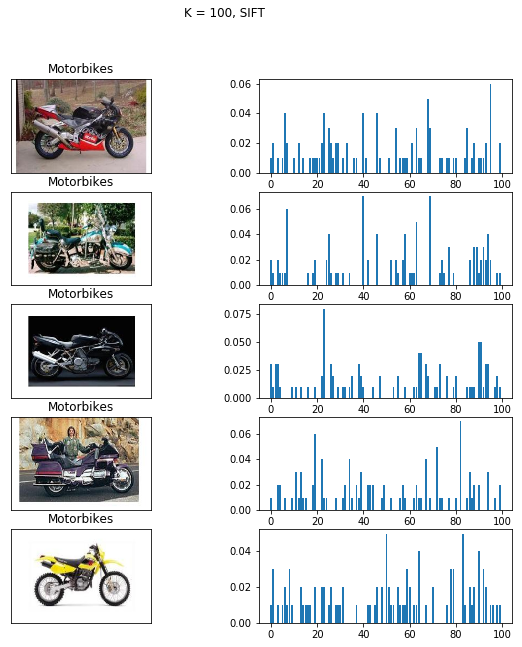

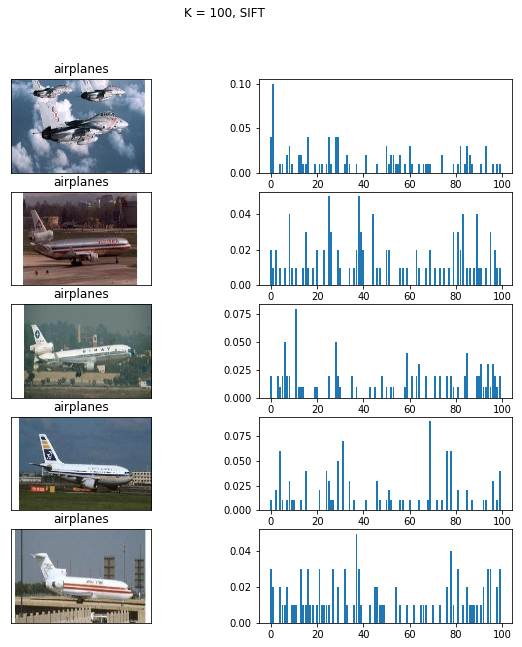

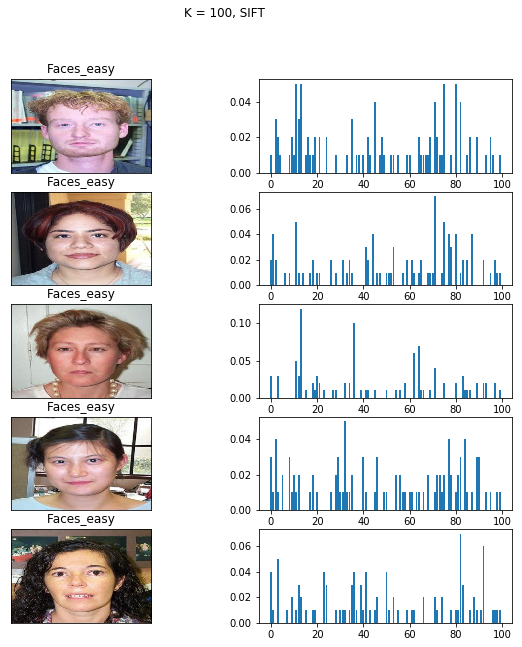

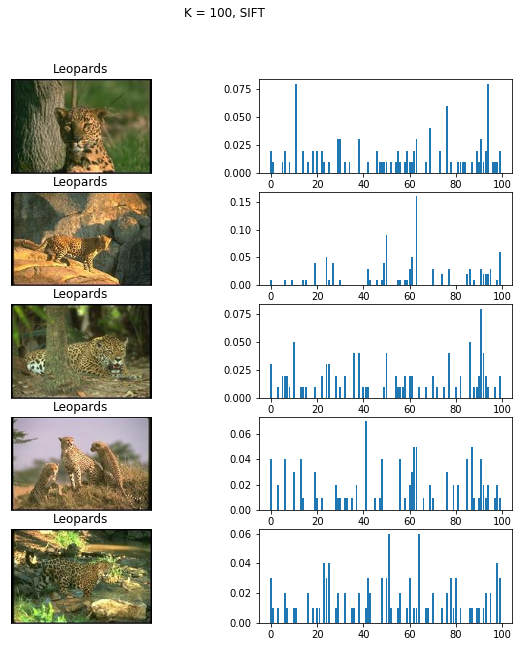

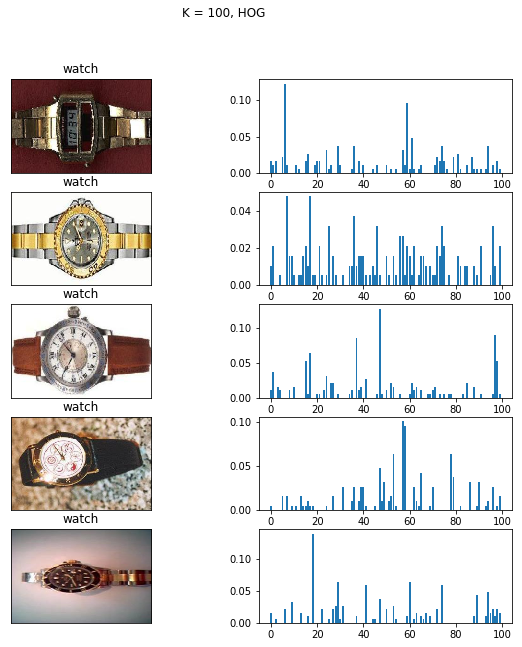

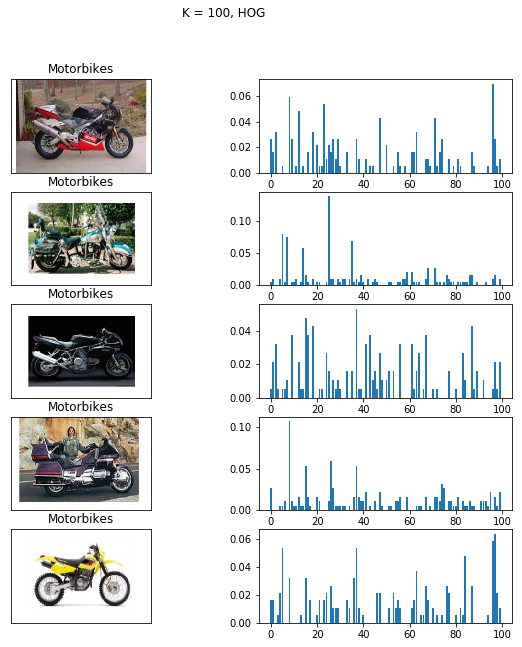

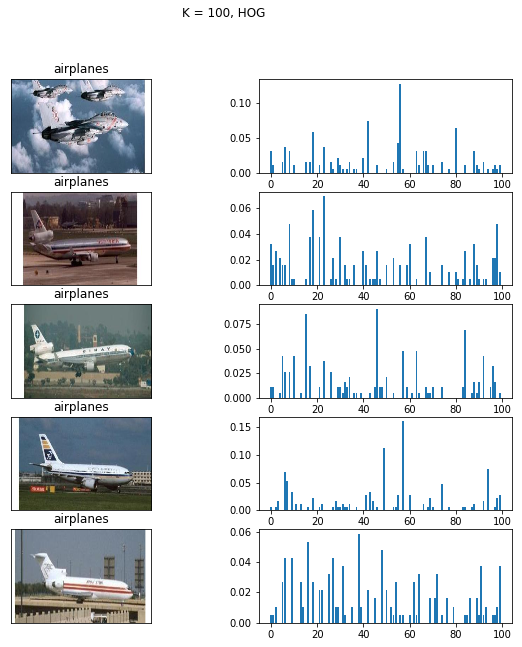

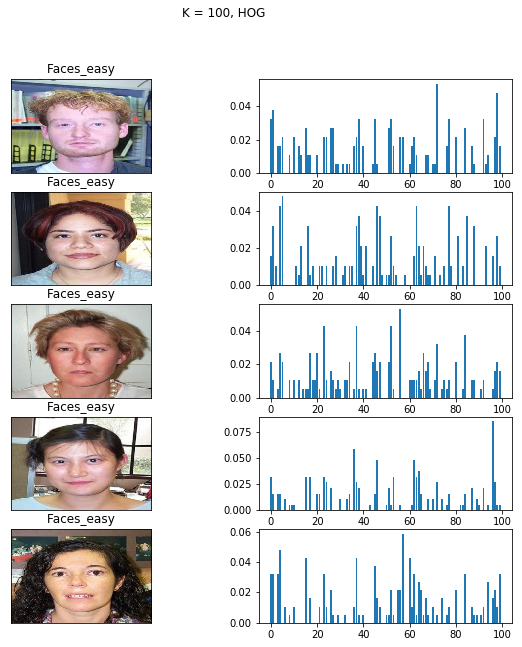

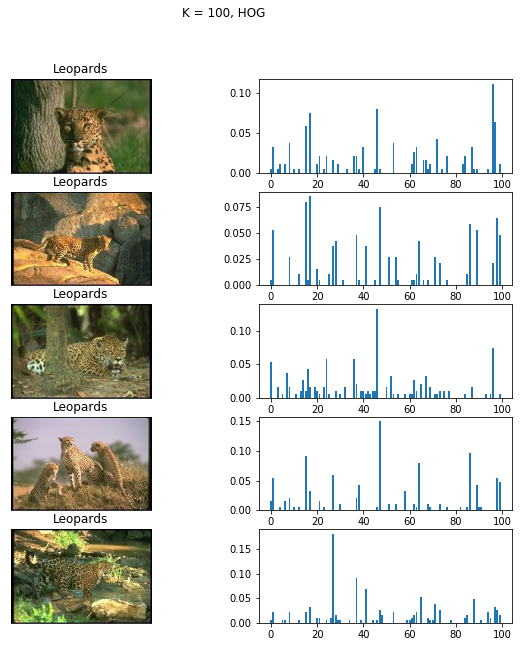

In [205]:
# set datapath
data_path = '/home/gary/Documents/ECSE415_Fall2017/Assignments/' \
     'Assign4/101_ObjectCategories'

# read dataset
X, y, categories = read_caltect(data_path)
# compute SIFT features
X_sift = compute_SIFT(X, num_features=100)
# compute HoG features
X_hog = compute_HOG(X)
print('X_sift:', X_sift.shape)
print('X_hog:', X_hog.shape)
# split into training, validation, and testing datasets
datasets = split_dataset(X_sift, y)
Xtr_sift, ytr_sift, Xval_sift, yval_sift, Xte_sift, yte_sift = datasets
datasets = split_dataset(X_hog, y)
Xtr_hog, ytr_hog, Xval_hog, yval_hog, Xte_hog, yte_hog = datasets

# for each value of K
K = [25, 50, 100]
best_acc = 0
for k in K:
    # create Bag-of-Words object
    bow = BagOfWords(num_words=k)
    # train for SIFT features
    bow.train(Xtr_sift, ytr_sift)
    bow.display_images(X, X_sift, y, categories, 'SIFT')
    # train for HoG features
    bow.train(Xtr_hog, ytr_hog)
    bow.display_images(X, X_hog, y, categories, 'HOG')

## Problem 2 - Bag-of-Words Classification

In [215]:
# find best hyper-parameters
# for each value of K
K = np.arange(10, 160, 10)
for k in K:
    # create Bag-of-Words object
    bow = BagOfWords(num_words=k)
    # train for SIFT features
    bow.train(Xtr_sift, ytr_sift)
    acc_sift = bow.score(Xval_sift, yval_sift)
    print('Accuracy for K =', k, ', SIFT:', acc_sift*100, '%')
    # train for HoG features
    bow.train(Xtr_hog, ytr_hog)
    acc_hog = bow.score(Xval_hog, yval_hog)
    print('Accuracy for K =', k, ', HOG:', acc_hog*100, '%')

Accuracy for K = 10 , SIFT: 62.783171521 %
Accuracy for K = 10 , HOG: 63.430420712 %
Accuracy for K = 20 , SIFT: 67.3139158576 %
Accuracy for K = 20 , HOG: 78.640776699 %
Accuracy for K = 30 , SIFT: 66.6666666667 %
Accuracy for K = 30 , HOG: 81.8770226537 %
Accuracy for K = 40 , SIFT: 67.3139158576 %
Accuracy for K = 40 , HOG: 79.9352750809 %
Accuracy for K = 50 , SIFT: 66.3430420712 %
Accuracy for K = 50 , HOG: 78.9644012945 %
Accuracy for K = 60 , SIFT: 62.9449838188 %
Accuracy for K = 60 , HOG: 76.5372168285 %
Accuracy for K = 70 , SIFT: 65.3721682848 %
Accuracy for K = 70 , HOG: 81.8770226537 %
Accuracy for K = 80 , SIFT: 61.4886731392 %
Accuracy for K = 80 , HOG: 78.3171521036 %
Accuracy for K = 90 , SIFT: 63.2686084142 %
Accuracy for K = 90 , HOG: 76.5372168285 %
Accuracy for K = 100 , SIFT: 59.8705501618 %
Accuracy for K = 100 , HOG: 76.8608414239 %
Accuracy for K = 110 , SIFT: 60.6796116505 %
Accuracy for K = 110 , HOG: 81.8770226537 %
Accuracy for K = 120 , SIFT: 61.1650485437

In [217]:
# best hyper-parameters
k = 120
# create Bag-of-Words object
bow = BagOfWords(num_words=k)
bow.train(Xtr_hog, ytr_hog)
acc_hog = bow.score(Xte_hog, yte_hog)
print('Testing Accuracy for K =', k, ', HOG:', acc_hog*100, '%')

Testing Accuracy for K = 120 , HOG: 76.6990291262 %
